# SIR model
SIR modelling is a classical approach to model an epidemic at the population level. It's based on Ordinary Differential Equations (ODE), which describe the dynamics of the expected population size in different stages of the disease: that's why it's also called a compartimental model. The stages or categories in which the population is divided are:
- Susceptible (S): population that has the potential of being infected.
- Infected (I): infected population.
- Removed (R): population that is neither susceptible, nor infected. It includes the recovered (since it's assumed that the recovered population develops an immunity) and the deceased people.

The main assumption in this model is that the total population N, which is $N = S + I + R$ is constant over time. Of course, this model is quite simplistic and doesn't take into account many factors, such as the presence of therapy, vaccination, quarantine and other measures that can be taken in the case of an epidemic.

This model can be described with the following system of ODE, that explains the rate at which the members of the population move from and to the groups of Susceptible, Infected and Removed:


$$
\begin{cases}
\frac{dS}{dt}=-\frac{\beta SI}{N}\\
\frac{dI}{dt}=\frac{\beta SI}{N} - \gamma I\\
\frac{dR}{dt}=\gamma I
\end{cases}
$$


In this formulation:
- $\beta$ is known as the **effective contact rate**: in a unit time it's expected that each infected individual will come into contact with $\beta N$ people, with N the total population (considered fixed).
- $\gamma$ is the **removal rate**: the number $\frac{1}{\gamma}$ defines the number of days during which a person stays infected.


By fitting this model on population-level data, it's possible to estimate the two parameters $\beta$ and $\gamma$.
Once properly fitted, if the model is sufficiently good it can be used to predict the size of each group of the population at any given time and, most importantly for the scope of this project, it can be useful to compute $R_{0}$, the **basic reproductive number**. This is an important value to take into consideration in order to evaluate the spread of an infectious disease. In fact, the higher is the value of $R_{0}$ for an infectious disease, the higher is the risk for its spread.

# Basic reproductive number
$R_{0}$ is a function of the probability of transmission for a single contact between an infected person and a susceptible one. Usually, this value can go from 0 to $+\infty$, with values higher than 1 indicating that the infection will spread infecting more and more people. In general, higher values of $R_{0}$ indicates an higher risk for the spread of the disease.\
$R_{0}$ is usually used as a threshold measure in order to evaluate the possible outcome of an infectious disease:
- If $R_{0}$>1 the disease will spread, generating an epidemic.
- If $R_{0}$<1 the disease can be restrained and the outbreak becomes extinct.

Once fitting the SIR model on real world data and obtaining the parameters $\beta$ and $\gamma$ that better fit the data itself, the basic reproductive number can be computed as:


$$
R_{0} = \frac{\beta}{\gamma}
$$



# Modified SIR model
Since the total population N at each day that is  considered corresponds to the people tested for COVID-19 daily, the assumption for N to be constant cannot be considered as true.\
In this case, it is better to relativize the variables of the model by normalizing them with respect to N. The variables s, i and r will then correspond to the percentage of Susceptible, Infected and Removed with respect to the total population considered:

$$
s = \left(\frac{S}{N}\right),   i = \left(\frac{I}{N}\right),   r = \left(\frac{R}{N}\right)
$$

In this way, the following system of ODE is obtained:


$$
\begin{cases}
\frac{ds}{dt}=-\beta si\\
\frac{di}{dt}=\beta si - \gamma i\\
\frac{dr}{dt}=\gamma i\\
\end{cases}
$$



# $R_{0}$ computation through the modified SIR model
To compute $R_{0}$ with this model, the two parameters of the ODE ($\beta$ and $\gamma$) need to be computed such that the model fit properly the real world data (with the lowest possible errors).


## $\beta$  and $\gamma$ estimation
The parameters $\beta$ and $\gamma$ are computed through an optimization procedure. The difference between the predicted population components and the actual population components is minimized in order to compute the optimal parameters.\
The problem of finding $\beta$ and $\gamma$ then corresponds to solving the following optimization problem:


$$
\hat{\beta}, \hat{\gamma} = \textrm{argmin}_{\beta,\gamma}
\begin{cases}
\sum \limits _{t=t_{0}} ^{t_{0}+n} (s(t) - \hat{s(t)})^{2}\\
\sum \limits _{t=t_{0}} ^{t_{0}+n} (i(t) - \hat{i(t)})^{2}\\
\sum \limits _{t=t_{0}} ^{t_{0}+n} (r(t) - \hat{r(t)})^{2}\\
\end{cases}
$$

In this formulation:
- $t_{0}$ is the initial time point
- $n$ is the length of the time interval considered
- $i(t)$ is the percentage of infected at time $t$
- $\hat{i(t)}$ is the percentage of infected predicted by the model at time $t$
- $s(t)$ is the percentage of susceptible at time $t$
- $\hat{s(t)}$ is the percentage of susceptible predicted by the model at time $t$
- $r(t)$ is the percentage of susceptible at time $t$
- $\hat{r(t)}$ is the percentage of susceptible predicted by the model at time $t$

The estimates for s, i and r are computed by integrating and solving the ODE at each time $t$ of interest

# Loading packages
In order to perform all the computations and to visualize the data, the following packages are needed and imported:

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # don't show copy errors
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import fmin
from datetime import datetime

# The dataset
The data used to compute the $R_{0}$ is taken from Protezione Civile of Italy and it's stored on their github repository https://github.com/pcm-dpc/COVID-19 \
The dataset used to compute the $R_{0}$ is the one containing the national data, called `dati-andamento-nazionale` and it's imported as a pandas dataframe:

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv")
df.head()

,data,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,...,tamponi,casi_testati,note,ingressi_terapia_intensiva,note_test,note_casi,totale_positivi_test_molecolare,totale_positivi_test_antigenico_rapido,tamponi_test_molecolare,tamponi_test_antigenico_rapido
0,2020-02-24T18:00:00,ITA,101,26,127,94,221,0,221,1,...,4324,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-02-25T18:00:00,ITA,114,35,150,162,311,90,93,1,...,8623,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-02-26T18:00:00,ITA,128,36,164,221,385,74,78,3,...,9587,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-02-27T18:00:00,ITA,248,56,304,284,588,203,250,45,...,12014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-02-28T18:00:00,ITA,345,64,409,412,821,233,238,46,...,15695,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Building the dataset for the SIR model
First of all, the dataset needs to be processed in order to better suit the needs to build the modified SIR model. The main variables that are needed are:
- Total population at each time ($N(t)$): the total population considered in each day (tested people). This variable can be found in the column `tamponi` of the dataset.
- Susceptible population at each time ($S(t)$): it's computed as the difference between the total population N at each day minus the infected population at time t ($I(t)$) and the removed population at time t ($R(t)$):

$$S(t) = N(t) - I(t) - R(t)$$


- Infected population at each time ($I(t)$): this data can be found in the column `nuovi_positivi`.

- Removed population at each time ($R(t)$): this is composed by the recovered ($E(t)$) and the deaths ($D(t)$) at each time, which are respectively stored in the columns `dimessi guariti` and `deceduti` of the dataset:

$$R(t) = E(t) + D(t)$$

Since there's a lot of weekly variability in the data (tests performed are usually less in the weekends), all the data used is averaged with a rolling window of 7 days. With this operation, the first and last three rows of the dataset need to be removed as they will contain NaN.\
Once obtained the S, I and R variables from the dataset, it is possible to compute the relative variables by dividing them by N.

The following functions will perform all the preprocessing needed:
- `preprocessing()` will extract and compute from the original dataset all the variables that are needed for the relative SIR model and for the plotting performed in the last part of this notebook.
- `build_relative_SIR()` will take as input the dataframe preprocessed with the previous function and build the dataframe with the previously mentioned variables s, i and r that are needed for the relative SIR model. The output of this function will be the dataset used to compute the $R_{0}$

In [3]:
def preprocessing(df):
    
    """Preprocess the original dataframe in order to extract only the useful
    informations and compute the necessary quantities for R0 computing and plotting"""
    
    # Compute S, I, R, N with rolling window average
    df["Date"] = df.data.str.slice(0,10)
    df["N"] = df.tamponi
    df["Averaged_N"] = df.tamponi.rolling(window=7, center=True).mean()
    df["Infected"] = df.nuovi_positivi
    df["Averaged_Infected"] = df.Infected.rolling(window=7, center=True).mean()
    df["Deaths"] = df.deceduti - df.deceduti.shift(1,fill_value=0)
    df["Averaged_Deaths"] = df.Deaths.rolling(window=7, center=True).mean()
    df["Recovered"] = df.dimessi_guariti - df.dimessi_guariti.shift(1,fill_value=0)
    df["Averaged_Recovered"] = df.Recovered.rolling(window=7, center=True).mean()
    df["Averaged_Removed"] = df.Averaged_Deaths + df.Averaged_Recovered
    df["Averaged_Susceptible"] = df.Averaged_N - df.Averaged_Infected - df.Averaged_Removed
    
    # Define the preprocessed dataframe
    new_df = df[["Date","Averaged_Susceptible","Infected","Averaged_Infected",
                 "Deaths","Averaged_Deaths","Recovered","Averaged_Recovered",
                 "Averaged_Removed","N","Averaged_N"]]
    
    # remove NaN caused by rolling window average
    new_df = new_df.dropna()
    
    # Set the indexes starting from 0
    new_df = new_df.set_index(np.array(range(0,len(new_df.index))))
    
    # Return the preprocessed dataframe with modified column names
    return new_df


def build_relative_SIR(df):
    
    """Build the data for the relative SIR model starting from the preprocessed dataframe"""
    
    # Define SIR dataframe with absolute measures
    SIR = df[["Averaged_Susceptible","Averaged_Infected","Averaged_Removed","Averaged_N"]].copy()
    
    # Compute relative measures
    SIR["Susceptible_percentage"] = SIR["Averaged_Susceptible"]/SIR["Averaged_N"]
    SIR["Infected_percentage"] = SIR["Averaged_Infected"]/SIR["Averaged_N"]
    SIR["Removed_percentage"] = SIR["Averaged_Removed"]/SIR["Averaged_N"]
    
    # Define sir dataframe with relative measures
    sir = SIR[["Susceptible_percentage","Infected_percentage","Removed_percentage"]]

    return sir

In [4]:
# Preprocess the original dataset (this will be used mainly for plotting)
preprocessed_df = preprocessing(df)
preprocessed_df.head()

,Date,Averaged_Susceptible,Infected,Averaged_Infected,Deaths,Averaged_Deaths,Recovered,Averaged_Recovered,Averaged_Removed,N,Averaged_N
0,2020-02-27,12604.000000,250,240.857143,5,4.857143,42,11.857143,16.714286,12014,12861.571429
1,2020-02-28,15293.142857,238,258.142857,4,6.428571,1,21.142857,27.571429,15695,15578.857143
2,2020-02-29,17696.714286,240,311.428571,8,9.857143,4,22.714286,32.571429,18661,18040.714286
3,2020-03-01,20496.857143,566,384.142857,5,13.571429,33,39.000000,52.571429,21127,20933.571429
4,2020-03-02,23310.714286,342,458.285714,18,18.714286,66,52.714286,71.428571,23345,23840.428571


In [5]:
# Build the dataset to compute R0 through the relative SIR model
SIR_relative = build_relative_SIR(preprocessed_df)
SIR_relative.head()

,Susceptible_percentage,Infected_percentage,Removed_percentage
0,0.979974,0.018727,0.001300
1,0.981660,0.016570,0.001770
2,0.980932,0.017263,0.001805
3,0.979138,0.018351,0.002511
4,0.977781,0.019223,0.002996


# Modified SIR model implementation
With the following code, the estimation of the parameters for the modified SIR model is performed. Usually, the SIR model is applied on the data regarding the first outbreak of a disease, as later data in influenced by the measures of confinement which are usually imposed (e.g. quaratine, protective masks and so on).

Considering the period in which the first wave of COVID-19 happened in Italy, the model is applied on the first 21 days reported in the dataset. In fact, after this period of time, the peak of the infected is passed and the infected curve starts to go down. Considering further data would cause an underestimation for the $R_{0}$.\
In the following graph, we can observe the distribution of Infected, Recovered and Deaths in this period of time and it's possible to confirm that the curve of infected is non-decreasing.

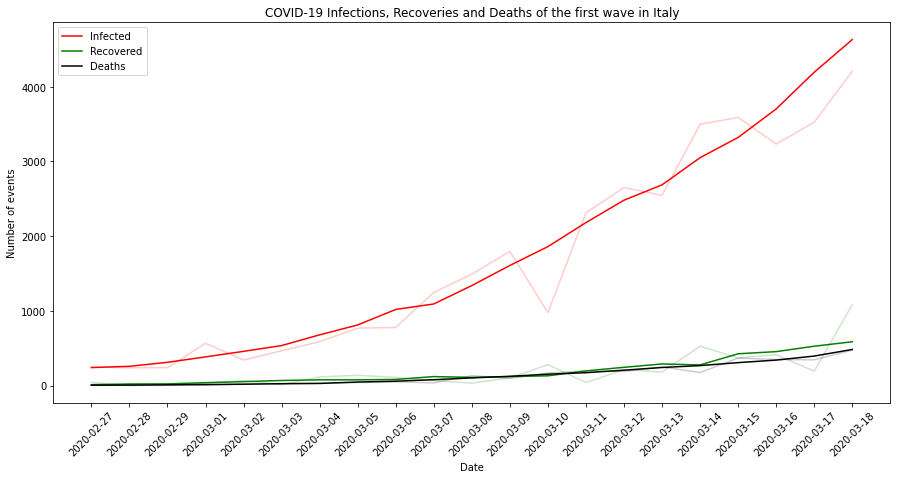

In [6]:
reduced_df = preprocessed_df.iloc[:21,]
plt.figure(figsize=(15,7))

# Plot data
g = sns.lineplot(data=reduced_df, x="Date", y="Infected", color="red", alpha=0.2)
g = sns.lineplot(data=reduced_df, x="Date", y="Recovered", color="green", alpha=0.2)
g = sns.lineplot(data=reduced_df, x="Date", y="Deaths", color="black", alpha=0.2)

# Plot averaged data
g = sns.lineplot(data=reduced_df, x="Date", y="Averaged_Infected", label="Infected", color="red")
g = sns.lineplot(data=reduced_df, x="Date", y="Averaged_Recovered", label="Recovered", color="green")
g = sns.lineplot(data=reduced_df, x="Date", y="Averaged_Deaths", label="Deaths", color="black")

plt.xticks(rotation=45)

g.set_xlabel("Date")
g.set_ylabel("Number of events")
g.set_title("COVID-19 Infections, Recoveries and Deaths of the first wave in Italy")

plt.show()

## $\beta$ and $\gamma$ estimation
$\beta$ and $\gamma$ are estimated through an optimization problem: the ODE containing the two parameters are solved through integration in the time points of interest starting from time 0, using the $\beta$ and $\gamma$ that reduce the discrepancy between the real data and the expected data from the model.\
The ODE are solved thanks to the `scipy.integrate` package, in particular with the `odeint()` function.\
The minimization procedure used for $\beta$ is the Nelder-Mead simplex algorithm, which doesn't make any assumption about the distribution of the data and is quite simple to use through the `scipy.optimize` package, in particular with the `fmin()` function.

As stated before, the optimization problem corresponds to the following formulation:

$$
\hat{\beta},\hat{\gamma} = \textrm{argmin}_{\beta,\gamma}
\begin{cases}
\sum \limits _{t=t_{0}} ^{t_{0}+n} (s(t) - \hat{s(t)})^{2}\\
\sum \limits _{t=t_{0}} ^{t_{0}+n} (i(t) - \hat{i(t)})^{2}\\
\sum \limits _{t=t_{0}} ^{t_{0}+n} (r(t) - \hat{r(t)})^{2}\\
\end{cases}
$$

In order to solve this optimization problem, the following ODE need to be solved in $\beta$ and $\gamma$:

$$
\begin{cases}
\frac{ds}{dt}=-\beta si\\
\frac{di}{dt}=\beta si - \gamma i\\
\frac{dr}{dt}=\gamma i
\end{cases}
$$

For obtaining $R_{0}$, the following three functions are needed:
- `function_sir()`: given a list containing the percentage of susceptible, infected, removed and the parameters beta and gamma, it returns a list containing the derivatives contained in the ODE system.
- `objective()`: objective function to be minimized in order to find the beta and gamma parameters such that the model fits better the data. It takes as input a list containing the beta and gamma parameter, and returns the sum of squared errors of the corresponding model.
- `compute_R0()`: solves the optimization problem by selecting the beta and gamma that minimizes the objective function. It takes as input the dataset for the relative SIR model, the start and end time points in which the computation should be done and the initializations for the beta and gamma parameters.

In [7]:
# Define the system of ordinary differential equations containing s, i and r derivatives
# This function computes the system of ODE for the relative SIR model
def function_sir(sir,t,beta,gamma):
    
    """Compute the system of ODE for the relative SIR model"""
    
    # sir = [s(t),i(t),r(t)]
    s = -beta*sir[0]*sir[1] # ds/dt derivative
    i = beta*sir[0]*sir[1] - gamma*sir[1] # di/dt derivative
    r = gamma*sir[1] # dr/dt derivative
    
    return [s,i,r]


# Define the objective function to optimize in order to find the best beta and gamma according to the data
# The optimization corresponds to minimize the squared errors between the predicted S,I,R and the actual S,I,R
def objective(betagamma, sir):
    
    """Objective function to be minimized for the parameters beta and gamma, it computes
    the sum of squared errors between the data and the model built through the ODE system"""
    
    # betagamma = [beta, gamma]
    beta = betagamma[0]
    gamma = betagamma[1]
    
    # Set time points in which the ODE will be solved
    time_interval = np.linspace(0,len(sir)+1,len(sir))
    
    # Solve the ODE
    sir_hat = odeint(function_sir, sir[0], time_interval, args=(beta,gamma))
    
    # Return the squared errors of the model
    return np.sum((sir-sir_hat)**2)


def compute_R0(sir, t0, tn, beta0, gamma0):
    
    """Function to compute the R0 on population-level data through least squared errors"""
    
    # Select column for S, I and R
    sir = sir[["Susceptible_percentage","Infected_percentage","Removed_percentage"]]
    
    # Minimize the objective function, obtaining the best beta and gamma
    best_betagamma = fmin(objective, (beta0,gamma0), args=(sir.iloc[t0:tn,].to_numpy(),))
    
    # Store best beta and best gamma in a variable
    best_beta = best_betagamma[0]
    best_gamma = best_betagamma[1]
    
    # Compute and return R0
    R0 = best_beta/best_gamma
    return R0

In [8]:
R0 = compute_R0(SIR_relative,0,21,1,1)

Optimization terminated successfully.
         Current function value: 0.000248
         Iterations: 84
         Function evaluations: 160


In [9]:
print(f"The computed R0 is: {R0}")

The computed R0 is: 3.0960518295439687


The resulting $R_{0}$ is approximately **3.1**, which is in line with the interval given by the IIS in Italy, which states that the estimate of COVID-19 $R_{0}$ is likely to be between 1.4 and 3.8 [1]. The fact that this estimate is in the upper part of this interval may be due to the fact that the tests in the first wave of COVID in Italy were not covering a big part of the population and were biased toward symptomatic people.

# Data visualization
With the following function, we can plot the trends for cases of COVID-19 infections, deaths and recoveries in Italy, in different periods of time:
- `date_to_datetime()` is a simple function that converts a string date (like it is found in the processed dataset) in a datetime object. In this way it's easier to evaluate if the passed dates are coherent with the dataset.
- `covid_plot()` uses `seaborn` package and some matplotlib functionalities to plot the data based on the options passed to the funciton. Starting from the preprocessed dataframe, it can show different period of times, different events (Infected, Recovered, Deaths) with averaged or not averaged values.

In [10]:
def date_to_datetime(date_string):
    
    """Convert date in the form of a string ('yyyy-mm-dd') into a datetime object"""
    
    return datetime.strptime(date_string, '%Y-%m-%d')



def covid_plot(df, start_date=None, end_date=None,
               show=["Infected","Recovered","Deaths"], show_average=True,
               title="COVID-19 cases in Italy", xlabel="Date",
               ylabel="Number of cases", figsize=(15,7)):
    
    """Plot covid data from the preprocessed dataframe"""
    
    min_date = df.Date.iloc[0] # minimum possible date string
    max_date = df.Date.iloc[len(df.index)-1] # maximum possible date string
    min_dt = date_to_datetime(min_date) # minimum possible datetime object
    max_dt = date_to_datetime(max_date) # maximum possible datetime object
    
    # Set start and end to first and last date in the dataset if they are not set
    if start_date == None:
        start_date = min_date
    if end_date == None:
        end_date = max_date
    
    # Check that the start_date and end_date are proper values
    start_dt = date_to_datetime(start_date)
    end_dt = date_to_datetime(end_date)
    if start_dt > end_dt or start_dt < min_dt or end_dt < min_dt or start_dt > max_dt or end_dt > max_dt:
        raise Exception("Invalid dates")

    # Prepare the reduced dataset to be plotted
    start = df[df["Date"]==start_date].index[0]
    end = df[df["Date"]==end_date].index[0]
    reduced_df = df.iloc[start:end,]
    
    # Set figure size
    plt.figure(figsize=figsize)
        
    # Select events to be plotted and their corrispective colors
    event_color_dict = {"Infected":"red","Recovered":"green","Deaths":"black"}
    show_dict = {k: v for k, v in event_color_dict.items() if k in show}
    
    
    # Plot the data
    for event,color in show_dict.items():
        # plot non averaged data with same color as average but more transparent
        if show_average:
            g = sns.lineplot(data=reduced_df, x="Date", y=f"Averaged_{event}", label=event, color=color)
            g = sns.lineplot(data=reduced_df, x="Date", y=event, color=color, alpha=0.2)
        # plot only non averaged data
        else:
            g = sns.lineplot(data=reduced_df, x="Date", y=event, label=event, color=color)
            
    
    # Set density for x labels, such that they don't overlap
    if len(reduced_df.index)>50:
        n = round(len(reduced_df.index)/50)
        for index, label in enumerate(g.get_xticklabels()):
            if index % n == 0:  # every 10th label is kept
                label.set_visible(True)
            else:
                label.set_visible(False)
    
    # Make x axis labels vertical, so that they are more readable
    plt.xticks(rotation=90)
    
    # Set labels and title for the plot
    g.set_xlabel(xlabel)
    g.set_ylabel(ylabel)
    g.set_title(title)
    
    # Show the plot
    plt.show()

This function can now be used to plot the trends of COVID-19 cases in Italy over the period of time present in the dataset.

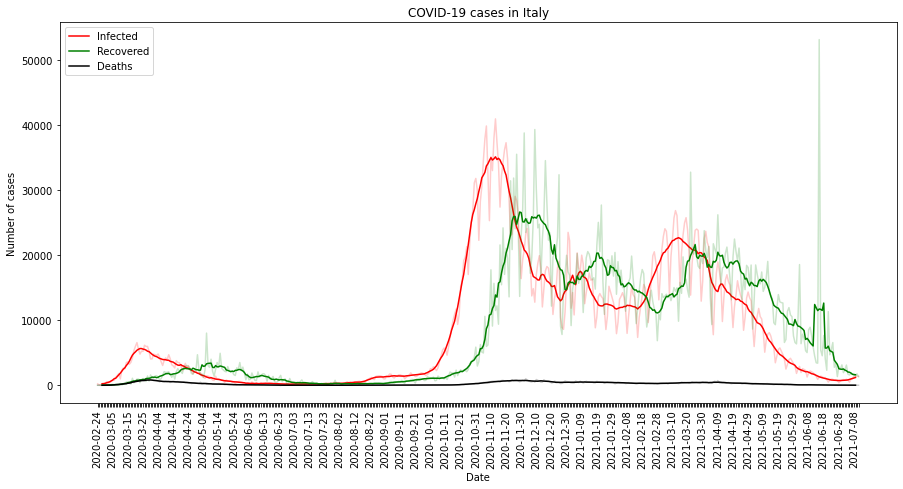

In [11]:
covid_plot(df, start_date=None, end_date=None, show=["Infected","Recovered","Deaths"],
           show_average=True, title="COVID-19 cases in Italy", xlabel="Date",
           ylabel="Number of cases", figsize=(15,7))

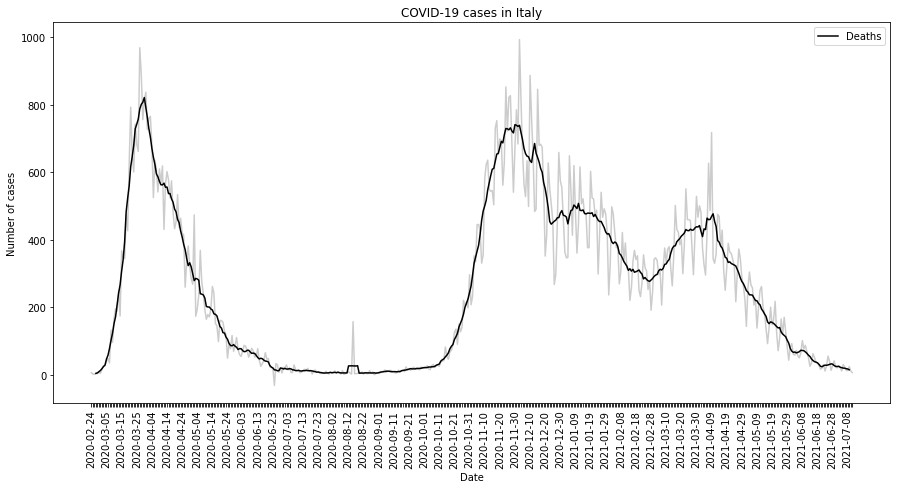

In [12]:
# Show death cases as they are not easily seen in the previous graph due to y axis scale
covid_plot(df, start_date=None, end_date=None, show="Deaths", show_average=True,
           title="COVID-19 cases in Italy", xlabel="Date", ylabel="Number of cases",
           figsize=(15,7))

# Interactive plotting with ipywidgets
With ipywidgets, it can be possible to interactively plot the data of interest in different ways, for example by selecting only some regions or a specific period of time. With the following code it is possible for the user to directly input some parameters to plot the data.
The following packages are needed for this implementation:

In [13]:
# Show multiple outputs from a single cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Import packages
import ipywidgets as widgets
from datetime import date
from datetime import datetime
from datetime import timedelta

The dataset containing all the regions and the previously imported national dataset are used:

In [14]:
df_regions = pd.read_csv("https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv")
df_regions.head()

,data,stato,codice_regione,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,...,note,ingressi_terapia_intensiva,note_test,note_casi,totale_positivi_test_molecolare,totale_positivi_test_antigenico_rapido,tamponi_test_molecolare,tamponi_test_antigenico_rapido,codice_nuts_1,codice_nuts_2
0,2020-02-24T18:00:00,ITA,13,Abruzzo,42.351222,13.398438,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-02-24T18:00:00,ITA,17,Basilicata,40.639471,15.805148,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-02-24T18:00:00,ITA,18,Calabria,38.905976,16.594402,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-02-24T18:00:00,ITA,15,Campania,40.839566,14.250850,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-02-24T18:00:00,ITA,8,Emilia-Romagna,44.494367,11.341721,10,2,12,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


For making an interactive plot, other two functions are defined:
- `filter_region()` will allow to filter from the regions dataframe the data about the region selected by the user. the filtered dataframe will then be preprocessed and used for plotting
- `widget_covid_plot()` will take as input the parameters passed by the user through the widgets, and make one or more plot (depending on the selection(s) of the user) by using the previously defined `preprocessing()` and `covid_plot()` function. A different plot will be made for each region selected.

In [15]:
def filter_region(df_regions, region):
    
    """Filter a dataframe based on the region"""
    
    df_region = df_regions[df_regions["denominazione_regione"]==region]
    return df_region



def widget_covid_plot(regions,start,end,event,average):
    
    """Plot covid data based on widgets selection"""
    
    # Convert datetime objects from widget into strings
    start_date = start.strftime("%Y-%m-%d")
    end_date = end.strftime("%Y-%m-%d")
    
    # Set the event variable based on widget selection
    event = ["Infected","Recovered","Deaths"] if event[0]=="All" else event
    
    # Preprocess data and make a plot for every region selected
    for region in regions:
        # Plot national data if "All" is selected
        if region == "All":
            preprocessed_df = preprocessing(df)
            title = f"COVID-19 cases of {', '.join(event)} in Italy"
            covid_plot(preprocessed_df, start_date=start_date, end_date=end_date,
                       show=list(event), show_average=average, title=title,
                       xlabel="Date", ylabel="Number of cases")
        else:
            df_region = filter_region(df_regions, region)
            preprocessed_region = preprocessing(df_region)
            title = f"COVID-19 cases of {', '.join(event)} in {region}"
            covid_plot(preprocessed_region, start_date=start_date, end_date=end_date,
                       show=list(event), show_average=average, title=title,
                       xlabel="Date", ylabel="Number of cases")

In the following code the widget for user input are defined:
- Multiple selection widget for selecting regions: multiple values can be selected by `ctrl + left click` or `shift + left click`. If more than one region is selected, more than one plot will be displayed. By selecting `All` the plot with national data will be displayed.
- Date selection widgets for both starting day and ending day to be displayed. The minimum possible date is 27/02/2020 and the maximum possible date is four days before the date in which the dataset is imported from the github repository.
- Multiple selection widget for selecting the event of interest: as for the first widget, multiple values can be selected. If `All` is selected, all the events (Infected, Recovered and Deaths) will be displayed.
- Checkbox widget for showing the averaged values: if not checked, the real data with daily variation will be displayed; if checked, the real data is still shown but with a more transparent color, while the data averaged with a rolling window of 7 days is displayed with a stronger color.

In [16]:
# Variables useful for widget functionalities
regions = ["All"]+df_regions['denominazione_regione'].unique().tolist()
events = ["All","Infected","Recovered","Deaths"]
four_days_ago = datetime.now() - timedelta(days=4)

# Widgets
region_w = widgets.SelectMultiple(options=regions, value=['All'], description='Regions:',
                                  rows=int(len(regions)/2))
start_w = widgets.DatePicker(description='Starting day:', value = datetime(2020,2,27))
end_w = widgets.DatePicker(description='Ending day:', value = four_days_ago)
event_w = widgets.SelectMultiple(options=events, value=['All'], description='Event(s)')
average_w = widgets.Checkbox(description='Show averaged values', value=True)

Then, the widget are displayed through the `interact_manual` command: in this way, since the plotting may take some time, the plots will be displayed (differently based on the inputs) only after pressing `Show plot`.

In [17]:
output = widgets.interact_manual(widget_covid_plot, regions=region_w, start=start_w,
                        end=end_w, event=event_w, average=average_w)
output.widget.children[5].description = 'Show plot'

interactive(children=(SelectMultiple(description='Regions:', index=(0,), options=('All', 'Abruzzo', 'Basilicat…

# References
1. $R_{0}$ information, ISS: https://www.iss.it/covid-19-primo-piano/-/asset_publisher/yX1afjCDBkWH/content/che-cos-%25C3%25A8-r0-e-perch%25C3%25A9-%25C3%25A8-cos%25C3%25AC-importante